# Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
best_model_path = "CoAtNet-1-Best-Both.pkl"
model_path = "CoAtNet-1-Both.pkl"

# best_model_path = "CoAtNet-1-Best-Zoom.pkl"
# model_path = "CoAtNet-1-Zoom.pkl"

# Model

In [3]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [4]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [5]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [6]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [7]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [8]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [9]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [10]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [11]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [12]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [13]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

/mnt/c/Users/seyyedaliayati/Documents/CSCE689_LLM/venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Stem: 2-1                                        --
|    |    └─Conv2d: 3-1                                 640
|    |    └─BatchNorm2d: 3-2                            128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,928
├─Sequential: 1-2                                       --
|    └─DownsamplingMBConv: 2-2                          --
|    |    └─Sequential: 3-5                             78,304
|    |    └─Conv2d: 3-6                                 6,144
|    |    └─MaxPool2d: 3-7                              --
|    └─MBConv: 2-3                                      --
|    |    └─Sequential: 3-8                             154,176
├─Sequential: 1-3                                       --
|    └─DownsamplingMBConv: 2-4                          --


Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Stem: 2-1                                        --
|    |    └─Conv2d: 3-1                                 640
|    |    └─BatchNorm2d: 3-2                            128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,928
├─Sequential: 1-2                                       --
|    └─DownsamplingMBConv: 2-2                          --
|    |    └─Sequential: 3-5                             78,304
|    |    └─Conv2d: 3-6                                 6,144
|    |    └─MaxPool2d: 3-7                              --
|    └─MBConv: 2-3                                      --
|    |    └─Sequential: 3-8                             154,176
├─Sequential: 1-3                                       --
|    └─DownsamplingMBConv: 2-4                          --
|    |    └─Sequential: 3-9      

# Load the model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

# Dataset Phone

In [16]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.labels = set()  # To track unique labels
        self.load_audio_files(self.data_dir)

    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                label = dirname.split('/')[-1]
       
                # my implementation start
                if '0' <= label <= '9':
                    label_index = ord(label) - ord('0')
                elif 'a' <= label <= 'z':
                    label_index = ord(label) - ord('a') + 10
                else:
                    raise ValueError(f"Unexpected label: {label}")
                    break
                label_tensor = torch.tensor(label_index)
                # my implementation done
                
                # Add the label to the set of unique labels
                self.labels.add(label_tensor.item())
                
                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label_tensor))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

    def num_classes(self):
        return len(self.labels)  # Return the number of unique labels

In [18]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=2048, win_length=1024)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset_phone = AudioDataset('../new_dataset_phone', transforms)
print("number of classes:", dataset_phone.num_classes())

number of classes: 36


In [23]:
from sklearn.model_selection import train_test_split
import torch

# Assume your dataset has a 'targets' attribute or you can extract labels from it
targets = [data[1] for data in dataset_phone]  # Assuming dataset returns (data, label) pairs

# Split the dataset indices with stratification
train_indices, tmp_indices = train_test_split(
    range(len(dataset_phone)), 
    test_size=0.3,  # 30% of the data goes to val+test
    stratify=targets, 
    random_state=42
)

val_indices, test_indices = train_test_split(
    tmp_indices, 
    test_size=0.33,  # 33% of the 30% goes to the test set, i.e., 10% of the original dataset
    stratify=[targets[i] for i in tmp_indices],  # Ensure stratification for val and test
    random_state=42
)

# Create subsets of the dataset based on the indices
init_train_set = torch.utils.data.Subset(dataset_phone, train_indices)
init_val_set = torch.utils.data.Subset(dataset_phone, val_indices)
init_test_set = torch.utils.data.Subset(dataset_phone, test_indices)

# Print the sizes for verification
print("Sample rate:", sample_rate)
print(f"Train set size: {len(init_train_set)}, Validation set size: {len(init_val_set)}, Test set size: {len(init_test_set)}")


Sample rate: 44100
Train set size: 630, Validation set size: 180, Test set size: 90


In [24]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [25]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [26]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])

phone_train_set = TrainingDataset(init_train_set, aug_transforms)
phone_train_set_no_aug = TrainingDataset(init_train_set, transforms)
phone_val_set = TrainingDataset(init_val_set, transforms)
phone_test_set = TrainingDataset(init_test_set, transforms)

torch.Size([64, 64])


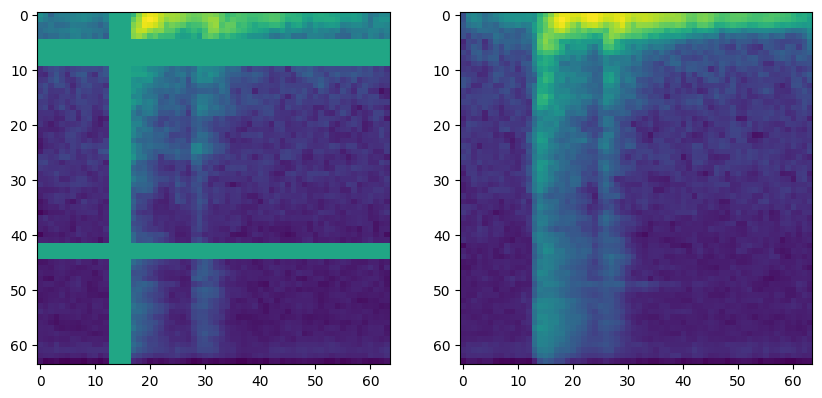

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(phone_train_set[0][0][0], cmap='viridis')
ax2.imshow(phone_val_set[0][0][0], cmap='viridis')
print(phone_train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [28]:
print("number of classes:", dataset_phone.num_classes())

number of classes: 36


In [29]:
phone_train_dataloader = torch.utils.data.DataLoader(
    phone_train_set,
    batch_size=16,
    shuffle=True
)

phone_val_dataloader = torch.utils.data.DataLoader(
    phone_val_set,
    batch_size=16,
    shuffle=True
)
phone_test_dataloader = torch.utils.data.DataLoader(
    phone_test_set,
    batch_size=16,
    shuffle=True
)

# Dataset Zoom

In [30]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [31]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [32]:
data_frame, sr = convert_to_df("../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

   Key                                               File
0    0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1    0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2    0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3    0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4    0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    int64 
 1   File    900 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.2+ KB
None


/tmp/ipykernel_91446/2608346354.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace=True)


In [33]:
zoom_train_set, tmp_set = train_test_split(data_frame, test_size=0.3, stratify=data_frame['Key'])
zoom_val_set, zoom_test_set = train_test_split(tmp_set, test_size=0.33, stratify=tmp_set['Key'])

print("Sample rate:", sr)
print(len(zoom_train_set), len(zoom_val_set), len(zoom_test_set))

Sample rate: 32000
630 180 90


In [34]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
zoom_train_set = MyDataset(zoom_train_set, aug = aug)
zoom_val_set = MyDataset(zoom_val_set, transform = transform)
zoom_test_set = MyDataset(zoom_test_set, transform = transform)

torch.Size([64, 64])


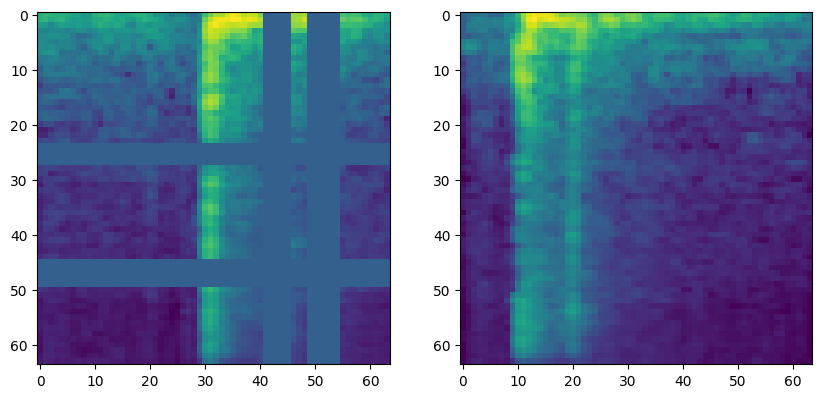

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(zoom_train_set[0][0][0], cmap='viridis')
ax2.imshow(zoom_val_set[0][0][0], cmap='viridis')
print(zoom_train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [36]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    zoom_train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    zoom_val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    zoom_test_set,
    batch_size=16,
    shuffle=True
)

# Combine Two Datasets

In [37]:
combined_train_set = torch.utils.data.ConcatDataset([phone_train_set, zoom_train_set])
combined_val_set = torch.utils.data.ConcatDataset([phone_val_set, zoom_val_set])
combined_test_set = torch.utils.data.ConcatDataset([phone_test_set, zoom_test_set])

def custom_collate_fn(batch):
    data, targets = zip(*batch)
    # Convert to tensors
    data = torch.stack([torch.tensor(d) for d in data])
    targets = torch.tensor(targets)  # If targets are scalar values
    return data, targets

# Use this collate function in your dataloaders
combined_train_dataloader = torch.utils.data.DataLoader(
    combined_train_set,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)

combined_val_dataloader = torch.utils.data.DataLoader(
    combined_val_set,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)

combined_test_dataloader = torch.utils.data.DataLoader(
    combined_test_set,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)


In [38]:
print(f"Combined train dataset length: {len(combined_train_set)}")
print(f"Combined validation dataset length: {len(combined_val_set)}")
print(f"Combined test dataset length: {len(combined_test_set)}")

for batch_data, batch_targets in combined_train_dataloader:
    print(f"Shape of one batch of data: {batch_data.shape}")
    print(f"Shape of one batch of targets: {batch_targets.shape}")
    break  # Only need to fetch and print one batch


Combined train dataset length: 1260
Combined validation dataset length: 360
Combined test dataset length: 180
Shape of one batch of data: torch.Size([16, 1, 64, 64])
Shape of one batch of targets: torch.Size([16])


/tmp/ipykernel_91446/3471023847.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack([torch.tensor(d) for d in data])


# Train

In [39]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [40]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [41]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [42]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

/tmp/ipykernel_91446/3471023847.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack([torch.tensor(d) for d in data])


Epoch [1/1100], Loss: 11.40456771850586, Accuracy: 0.031746031746031744 Correct: 40 Total: 1260 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.03333333333333333 Validation loss: 8.438989639282227 Correct: 12 Total: 360
Epoch [2/1100], Loss: 6.6087646484375, Accuracy: 0.03888888888888889 Correct: 49 Total: 1260 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.03333333333333333 Validation loss: 5.013627529144287 Correct: 12 Total: 360
Epoch [3/1100], Loss: 5.178638458251953, Accuracy: 0.02619047619047619 Correct: 33 Total: 1260 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.06111111111111111 Validation loss: 4.617275714874268 Correct: 22 Total: 360
Epoch [4/1100], Loss: 4.325129985809326, Accuracy: 0.049206349206349205 Correct: 62 Total: 1260 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.027777777777777776 Validation loss: 4.147899150848389 Correct: 10 Total: 360
Epoch [5/1100], Loss: 3.489093780517

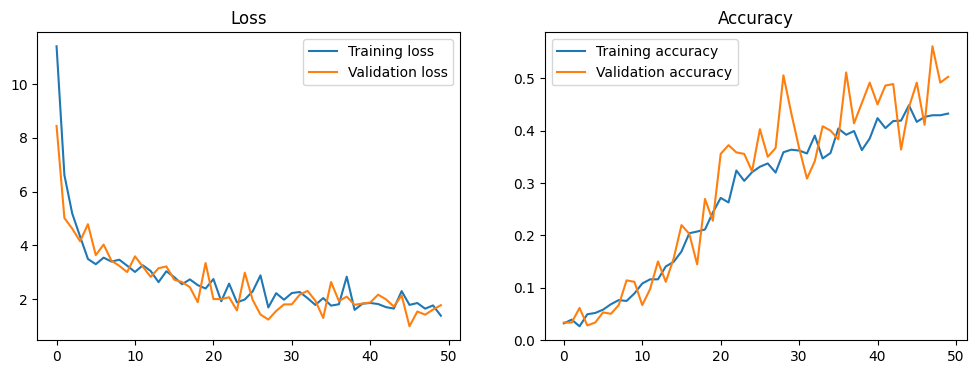

Epoch [51/1100], Loss: 2.1093642711639404, Accuracy: 0.4166666666666667 Correct: 525 Total: 1260 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.5583333333333333 Validation loss: 1.6106681823730469 Correct: 201 Total: 360
Epoch [52/1100], Loss: 1.5973995923995972, Accuracy: 0.41825396825396827 Correct: 527 Total: 1260 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.5694444444444444 Validation loss: 1.4000935554504395 Correct: 205 Total: 360
Epoch [53/1100], Loss: 2.286761522293091, Accuracy: 0.44761904761904764 Correct: 564 Total: 1260 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.5083333333333333 Validation loss: 1.3103803396224976 Correct: 183 Total: 360
Epoch [54/1100], Loss: 1.916153073310852, Accuracy: 0.4119047619047619 Correct: 519 Total: 1260 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.40555555555555556 Validation loss: 2.0621724128723145 Correct: 146 Total: 360
Epoch

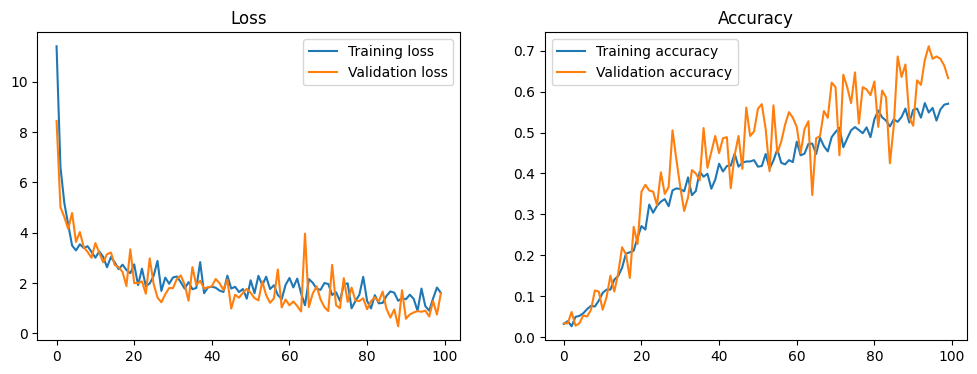

Epoch [101/1100], Loss: 1.8059788942337036, Accuracy: 0.5603174603174603 Correct: 706 Total: 1260 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.6972222222222222 Validation loss: 0.6739827990531921 Correct: 251 Total: 360
Epoch [102/1100], Loss: 1.9418894052505493, Accuracy: 0.5650793650793651 Correct: 712 Total: 1260 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.65 Validation loss: 0.8171403408050537 Correct: 234 Total: 360
Epoch [103/1100], Loss: 1.5042277574539185, Accuracy: 0.5666666666666667 Correct: 714 Total: 1260 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.7472222222222222 Validation loss: 0.35949549078941345 Correct: 269 Total: 360
Epoch [104/1100], Loss: 1.28206205368042, Accuracy: 0.5777777777777777 Correct: 728 Total: 1260 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.5361111111111111 Validation loss: 1.0909768342971802 Correct: 193 Total: 360
Epoch [105/1100]

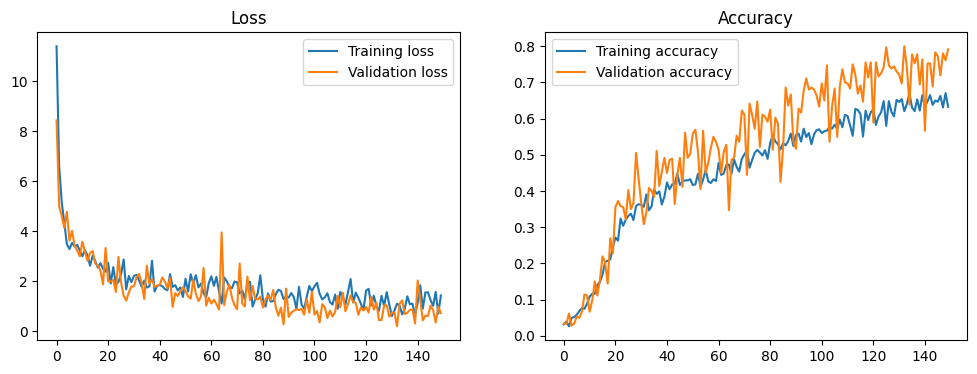

Epoch [151/1100], Loss: 1.266664981842041, Accuracy: 0.6634920634920635 Correct: 836 Total: 1260 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.7527777777777778 Validation loss: 1.045802116394043 Correct: 271 Total: 360
Epoch [152/1100], Loss: 0.6787754893302917, Accuracy: 0.6595238095238095 Correct: 831 Total: 1260 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.75 Validation loss: 0.6425724029541016 Correct: 270 Total: 360
Epoch [153/1100], Loss: 1.2063308954238892, Accuracy: 0.6912698412698413 Correct: 871 Total: 1260 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.6638888888888889 Validation loss: 1.1590261459350586 Correct: 239 Total: 360
Epoch [154/1100], Loss: 1.3194659948349, Accuracy: 0.6412698412698413 Correct: 808 Total: 1260 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.7888888888888889 Validation loss: 0.2200210839509964 Correct: 284 Total: 360
Epoch [155/1100], Los

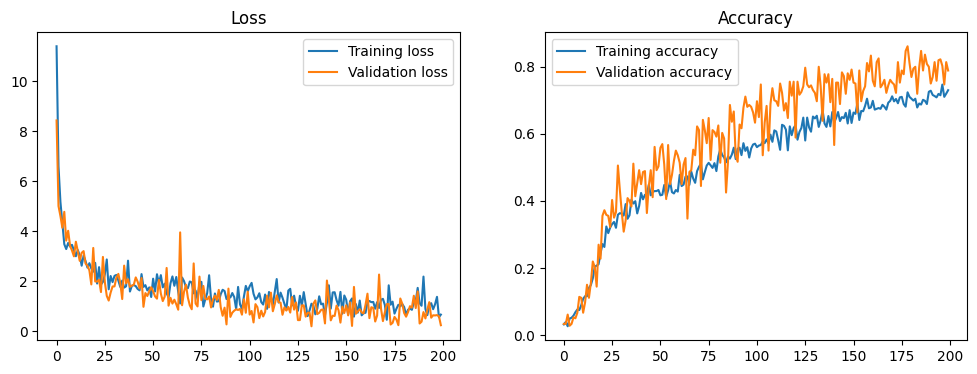

Epoch [201/1100], Loss: 1.5952690839767456, Accuracy: 0.7126984126984127 Correct: 898 Total: 1260 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.7666666666666667 Validation loss: 0.5738078951835632 Correct: 276 Total: 360
Epoch [202/1100], Loss: 0.8375136256217957, Accuracy: 0.7071428571428572 Correct: 891 Total: 1260 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.75 Validation loss: 0.6923534870147705 Correct: 270 Total: 360
Epoch [203/1100], Loss: 0.6933413147926331, Accuracy: 0.7103174603174603 Correct: 895 Total: 1260 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.7777777777777778 Validation loss: 0.4826505184173584 Correct: 280 Total: 360
Epoch [204/1100], Loss: 0.4053581953048706, Accuracy: 0.7373015873015873 Correct: 929 Total: 1260 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.7416666666666667 Validation loss: 0.692391037940979 Correct: 267 Total: 360
Epoch [205/1100

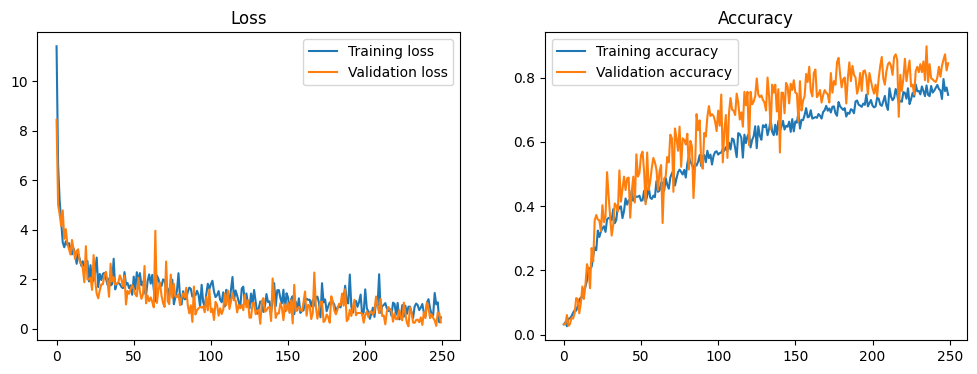

Epoch [251/1100], Loss: 0.4775528907775879, Accuracy: 0.7626984126984127 Correct: 961 Total: 1260 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8666666666666667 Validation loss: 0.28881123661994934 Correct: 312 Total: 360
Epoch [252/1100], Loss: 1.100585699081421, Accuracy: 0.7698412698412699 Correct: 970 Total: 1260 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.825 Validation loss: 0.0720406323671341 Correct: 297 Total: 360
Epoch [253/1100], Loss: 0.6452832818031311, Accuracy: 0.7761904761904762 Correct: 978 Total: 1260 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.8305555555555556 Validation loss: 0.4548546075820923 Correct: 299 Total: 360
Epoch [254/1100], Loss: 0.7427545189857483, Accuracy: 0.7888888888888889 Correct: 994 Total: 1260 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.8944444444444445 Validation loss: 0.3084529638290405 Correct: 322 Total: 360
Epoch [255/11

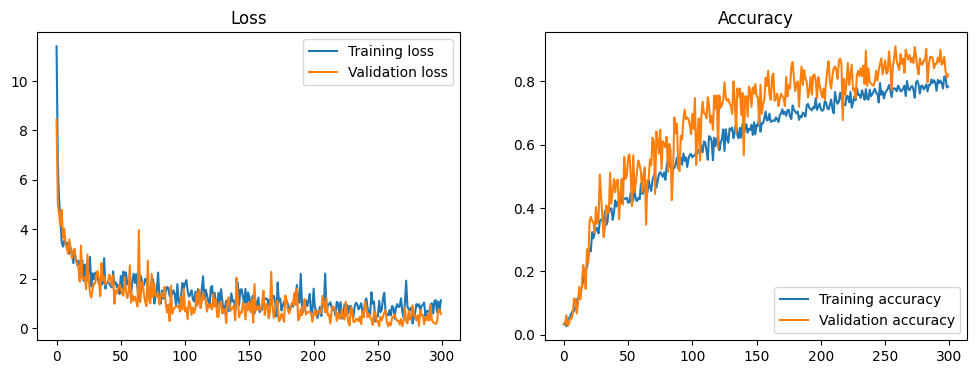

Epoch [301/1100], Loss: 0.5153911709785461, Accuracy: 0.7817460317460317 Correct: 985 Total: 1260 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8444444444444444 Validation loss: 0.3444965183734894 Correct: 304 Total: 360
Epoch [302/1100], Loss: 0.6942352652549744, Accuracy: 0.7992063492063493 Correct: 1007 Total: 1260 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8722222222222222 Validation loss: 0.9013159871101379 Correct: 314 Total: 360
Epoch [303/1100], Loss: 1.0358752012252808, Accuracy: 0.7817460317460317 Correct: 985 Total: 1260 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.8277777777777777 Validation loss: 0.281841516494751 Correct: 298 Total: 360
Epoch [304/1100], Loss: 0.6164942383766174, Accuracy: 0.7984126984126985 Correct: 1006 Total: 1260 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.8583333333333333 Validation loss: 0.8418099284172058 Correct: 309 Total: 360

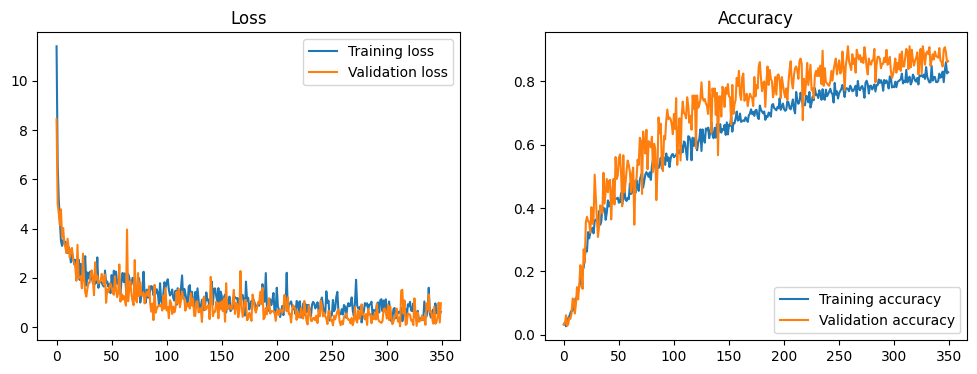

Epoch [351/1100], Loss: 0.35094335675239563, Accuracy: 0.8246031746031746 Correct: 1039 Total: 1260 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8666666666666667 Validation loss: 1.0445208549499512 Correct: 312 Total: 360
Epoch [352/1100], Loss: 0.6546540856361389, Accuracy: 0.8158730158730159 Correct: 1028 Total: 1260 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.8333333333333334 Validation loss: 0.4398132264614105 Correct: 300 Total: 360
Epoch [353/1100], Loss: 0.3680456578731537, Accuracy: 0.8134920634920635 Correct: 1025 Total: 1260 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.8722222222222222 Validation loss: 0.2647746801376343 Correct: 314 Total: 360
Epoch [354/1100], Loss: 0.6178991794586182, Accuracy: 0.8015873015873016 Correct: 1010 Total: 1260 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.9055555555555556 Validation loss: 0.5305882096290588 Correct: 326 Total: 36

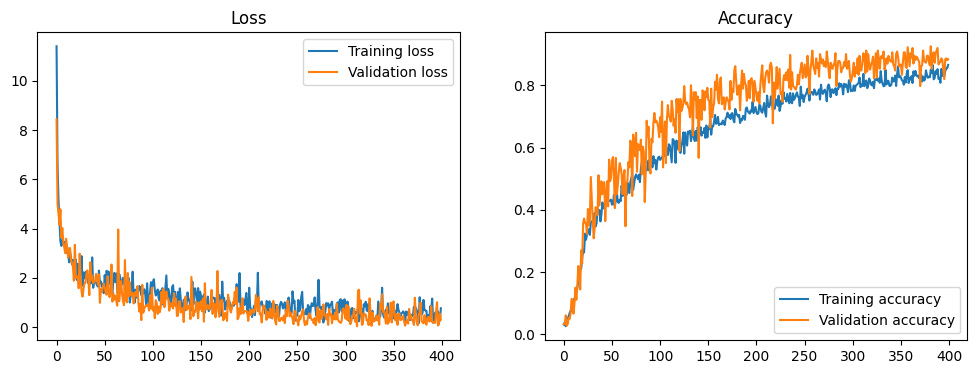

Epoch [401/1100], Loss: 1.4821791648864746, Accuracy: 0.8523809523809524 Correct: 1074 Total: 1260 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9111111111111111 Validation loss: 0.5390982627868652 Correct: 328 Total: 360
Epoch [402/1100], Loss: 0.887069046497345, Accuracy: 0.8515873015873016 Correct: 1073 Total: 1260 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.8833333333333333 Validation loss: 0.4406936466693878 Correct: 318 Total: 360
Epoch [403/1100], Loss: 0.657159149646759, Accuracy: 0.7880952380952381 Correct: 993 Total: 1260 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8833333333333333 Validation loss: 0.12884782254695892 Correct: 318 Total: 360
Epoch [404/1100], Loss: 0.43150344491004944, Accuracy: 0.8420634920634921 Correct: 1061 Total: 1260 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.875 Validation loss: 0.12803709506988525 Correct: 315 Total: 360
Epoch [40

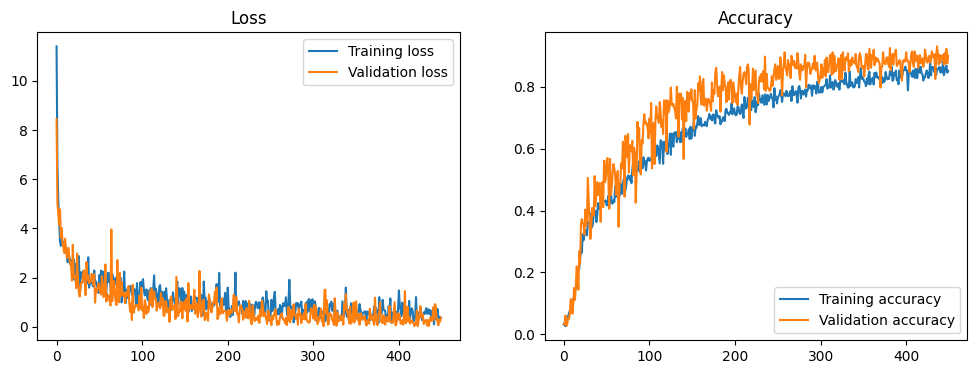

Epoch [451/1100], Loss: 0.20974884927272797, Accuracy: 0.8428571428571429 Correct: 1062 Total: 1260 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.8694444444444445 Validation loss: 0.49285829067230225 Correct: 313 Total: 360
Epoch [452/1100], Loss: 0.467885822057724, Accuracy: 0.8539682539682539 Correct: 1076 Total: 1260 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.9027777777777778 Validation loss: 0.3445846736431122 Correct: 325 Total: 360
Epoch [453/1100], Loss: 0.2018912434577942, Accuracy: 0.8626984126984127 Correct: 1087 Total: 1260 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.8805555555555555 Validation loss: 0.18088708817958832 Correct: 317 Total: 360
Epoch [454/1100], Loss: 0.6811859011650085, Accuracy: 0.8674603174603175 Correct: 1093 Total: 1260 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.9055555555555556 Validation loss: 0.573721706867218 Correct: 326 Total: 3

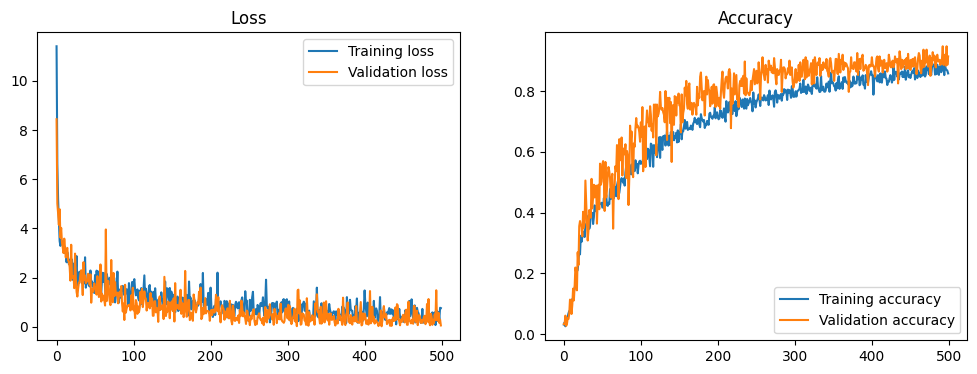

Epoch [501/1100], Loss: 0.5942525267601013, Accuracy: 0.8626984126984127 Correct: 1087 Total: 1260 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.9361111111111111 Validation loss: 0.10716953128576279 Correct: 337 Total: 360
Epoch [502/1100], Loss: 0.26097527146339417, Accuracy: 0.8825396825396825 Correct: 1112 Total: 1260 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.8805555555555555 Validation loss: 0.2852188050746918 Correct: 317 Total: 360
Epoch [503/1100], Loss: 0.2591020464897156, Accuracy: 0.8579365079365079 Correct: 1081 Total: 1260 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.8888888888888888 Validation loss: 0.12063604593276978 Correct: 320 Total: 360
Epoch [504/1100], Loss: 0.26323023438453674, Accuracy: 0.8746031746031746 Correct: 1102 Total: 1260 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.8888888888888888 Validation loss: 0.2843776345252991 Correct: 320 Tot

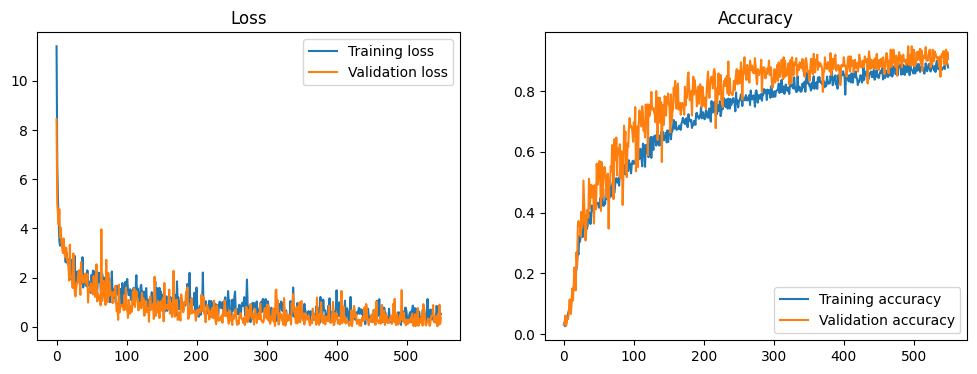

Epoch [551/1100], Loss: 0.49022606015205383, Accuracy: 0.8579365079365079 Correct: 1081 Total: 1260 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.9222222222222223 Validation loss: 0.060789648443460464 Correct: 332 Total: 360
Epoch [552/1100], Loss: 0.7581512928009033, Accuracy: 0.8841269841269841 Correct: 1114 Total: 1260 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.9166666666666666 Validation loss: 0.1385282278060913 Correct: 330 Total: 360
Epoch [553/1100], Loss: 0.5428464412689209, Accuracy: 0.8936507936507937 Correct: 1126 Total: 1260 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.8916666666666667 Validation loss: 0.44011205434799194 Correct: 321 Total: 360
Epoch [554/1100], Loss: 0.7421690821647644, Accuracy: 0.888095238095238 Correct: 1119 Total: 1260 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.9138888888888889 Validation loss: 0.03526328504085541 Correct: 329 Tot

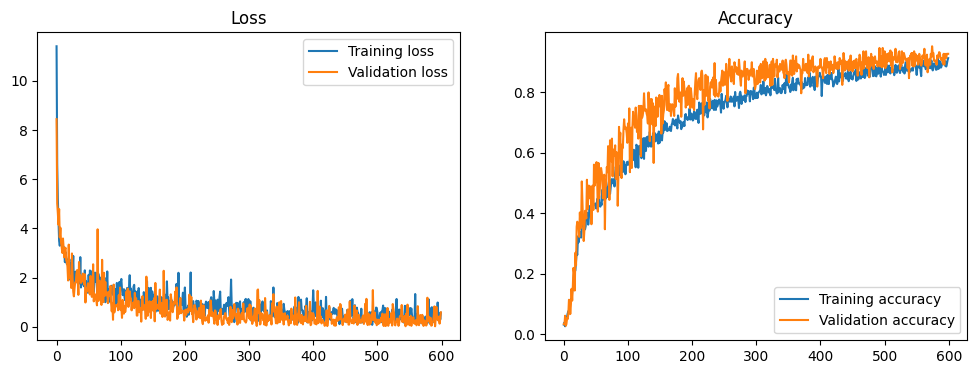

Epoch [601/1100], Loss: 0.14608611166477203, Accuracy: 0.8888888888888888 Correct: 1120 Total: 1260 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.9 Validation loss: 0.23935359716415405 Correct: 324 Total: 360
Epoch [602/1100], Loss: 0.7035694718360901, Accuracy: 0.9047619047619048 Correct: 1140 Total: 1260 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9166666666666666 Validation loss: 0.5383767485618591 Correct: 330 Total: 360
Epoch [603/1100], Loss: 0.46916699409484863, Accuracy: 0.9119047619047619 Correct: 1149 Total: 1260 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.8972222222222223 Validation loss: 0.18631917238235474 Correct: 323 Total: 360
Epoch [604/1100], Loss: 0.10130894929170609, Accuracy: 0.8896825396825396 Correct: 1121 Total: 1260 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9527777777777777 Validation loss: 0.9369606971740723 Correct: 343 Total: 360
Epoc

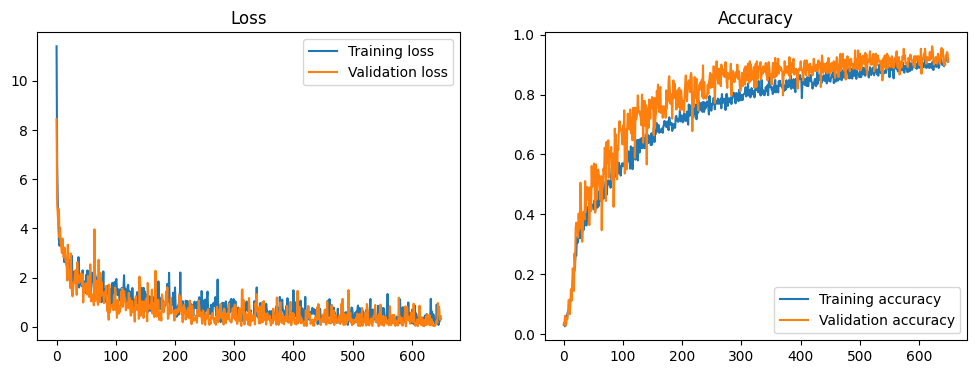

Epoch [651/1100], Loss: 0.1324003040790558, Accuracy: 0.9031746031746032 Correct: 1138 Total: 1260 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.95 Validation loss: 0.40108391642570496 Correct: 342 Total: 360
Epoch [652/1100], Loss: 0.13784323632717133, Accuracy: 0.9031746031746032 Correct: 1138 Total: 1260 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9416666666666667 Validation loss: 0.39239388704299927 Correct: 339 Total: 360
Epoch [653/1100], Loss: 0.399551123380661, Accuracy: 0.9214285714285714 Correct: 1161 Total: 1260 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9166666666666666 Validation loss: 0.2025851160287857 Correct: 330 Total: 360
Epoch [654/1100], Loss: 0.3182843029499054, Accuracy: 0.9063492063492063 Correct: 1142 Total: 1260 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.95 Validation loss: 0.09425870329141617 Correct: 342 Total: 360
Epoch [655/1100], Loss

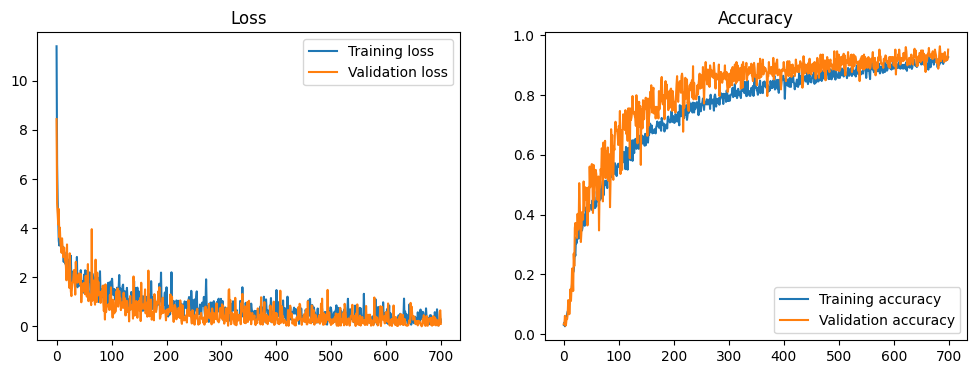

Epoch [701/1100], Loss: 0.2665800154209137, Accuracy: 0.9373015873015873 Correct: 1181 Total: 1260 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9333333333333333 Validation loss: 0.17236509919166565 Correct: 336 Total: 360
Epoch [702/1100], Loss: 0.4408128261566162, Accuracy: 0.9206349206349206 Correct: 1160 Total: 1260 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9277777777777778 Validation loss: 0.27108314633369446 Correct: 334 Total: 360
Epoch [703/1100], Loss: 0.19233179092407227, Accuracy: 0.9238095238095239 Correct: 1164 Total: 1260 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9166666666666666 Validation loss: 0.5438586473464966 Correct: 330 Total: 360
Epoch [704/1100], Loss: 0.3984545171260834, Accuracy: 0.9317460317460318 Correct: 1174 Total: 1260 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9166666666666666 Validation loss: 0.4808822274208069 Correct: 330 Tota

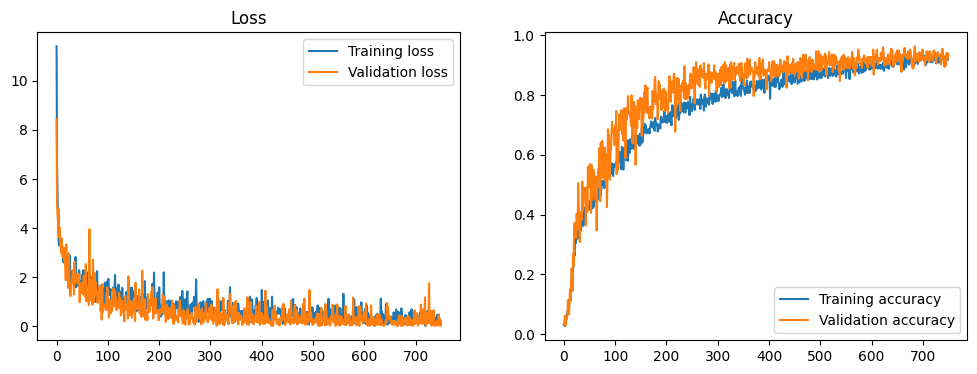

Epoch [751/1100], Loss: 0.15214882791042328, Accuracy: 0.9365079365079365 Correct: 1180 Total: 1260 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9333333333333333 Validation loss: 0.021686116233468056 Correct: 336 Total: 360
Epoch [752/1100], Loss: 0.16230283677577972, Accuracy: 0.9317460317460318 Correct: 1174 Total: 1260 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9277777777777778 Validation loss: 0.795097827911377 Correct: 334 Total: 360
Epoch [753/1100], Loss: 0.35870563983917236, Accuracy: 0.9214285714285714 Correct: 1161 Total: 1260 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9 Validation loss: 0.38829225301742554 Correct: 324 Total: 360
Epoch [754/1100], Loss: 0.2513597011566162, Accuracy: 0.9230158730158731 Correct: 1163 Total: 1260 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9194444444444444 Validation loss: 0.6278699636459351 Correct: 331 Total: 360
Epoch

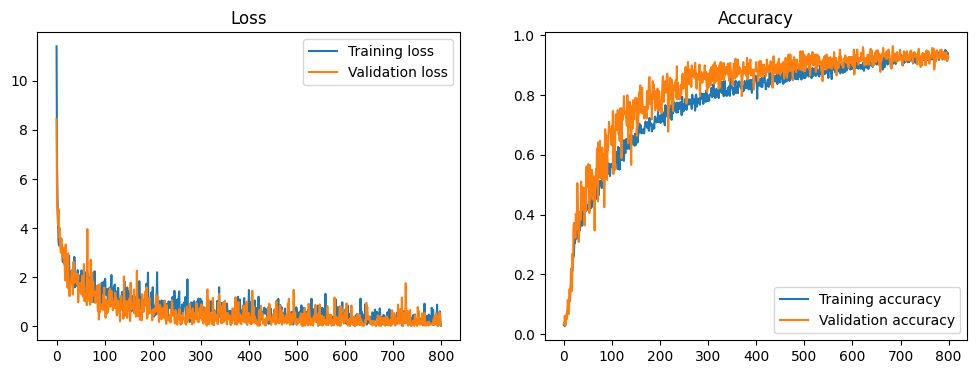

Epoch [801/1100], Loss: 0.2821027636528015, Accuracy: 0.9261904761904762 Correct: 1167 Total: 1260 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9361111111111111 Validation loss: 0.029903504997491837 Correct: 337 Total: 360
Epoch [802/1100], Loss: 0.4755370616912842, Accuracy: 0.9317460317460318 Correct: 1174 Total: 1260 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9277777777777778 Validation loss: 0.13006138801574707 Correct: 334 Total: 360
Epoch [803/1100], Loss: 0.409208744764328, Accuracy: 0.9412698412698413 Correct: 1186 Total: 1260 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9416666666666667 Validation loss: 0.20909900963306427 Correct: 339 Total: 360
Epoch [804/1100], Loss: 0.08106451481580734, Accuracy: 0.9357142857142857 Correct: 1179 Total: 1260 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9472222222222222 Validation loss: 0.5010079741477966 Correct: 341 Tota

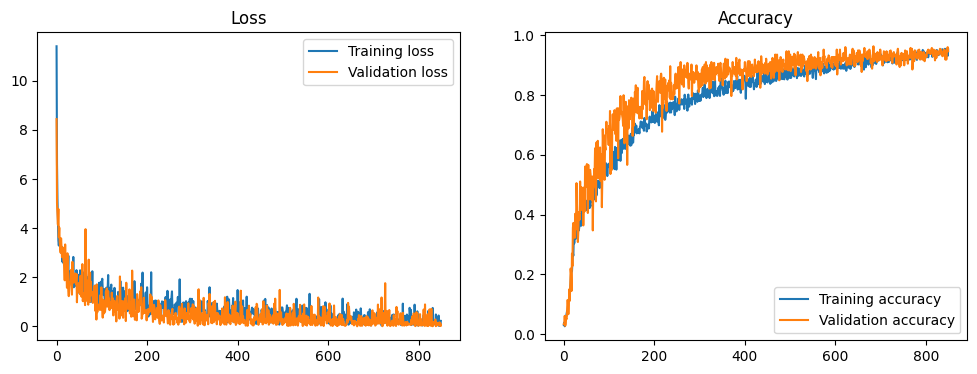

Epoch [851/1100], Loss: 0.39188244938850403, Accuracy: 0.9563492063492064 Correct: 1205 Total: 1260 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9388888888888889 Validation loss: 0.12802891433238983 Correct: 338 Total: 360
Epoch [852/1100], Loss: 0.3520878255367279, Accuracy: 0.9563492063492064 Correct: 1205 Total: 1260 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.95 Validation loss: 0.21383941173553467 Correct: 342 Total: 360
Epoch [853/1100], Loss: 0.1479559987783432, Accuracy: 0.953968253968254 Correct: 1202 Total: 1260 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9472222222222222 Validation loss: 0.22479316592216492 Correct: 341 Total: 360
Epoch [854/1100], Loss: 0.1495724767446518, Accuracy: 0.9492063492063492 Correct: 1196 Total: 1260 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9472222222222222 Validation loss: 0.08429861068725586 Correct: 341 Total: 360
Epo

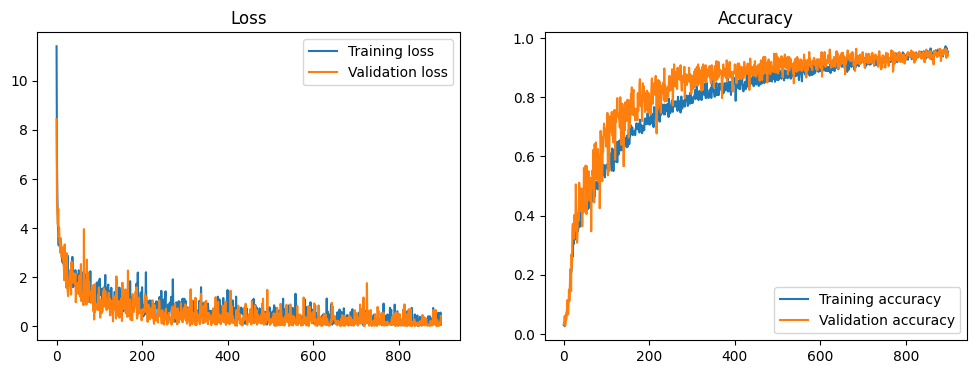

Epoch [901/1100], Loss: 0.1680508852005005, Accuracy: 0.9492063492063492 Correct: 1196 Total: 1260 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.024376271292567253 Correct: 344 Total: 360
Epoch [902/1100], Loss: 0.20493149757385254, Accuracy: 0.9619047619047619 Correct: 1212 Total: 1260 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9361111111111111 Validation loss: 0.006270310841500759 Correct: 337 Total: 360
Epoch [903/1100], Loss: 0.15553946793079376, Accuracy: 0.9515873015873015 Correct: 1199 Total: 1260 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9416666666666667 Validation loss: 0.3261461555957794 Correct: 339 Total: 360
Epoch [904/1100], Loss: 0.11000603437423706, Accuracy: 0.9571428571428572 Correct: 1206 Total: 1260 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.3877582848072052 Correct: 346 Tota

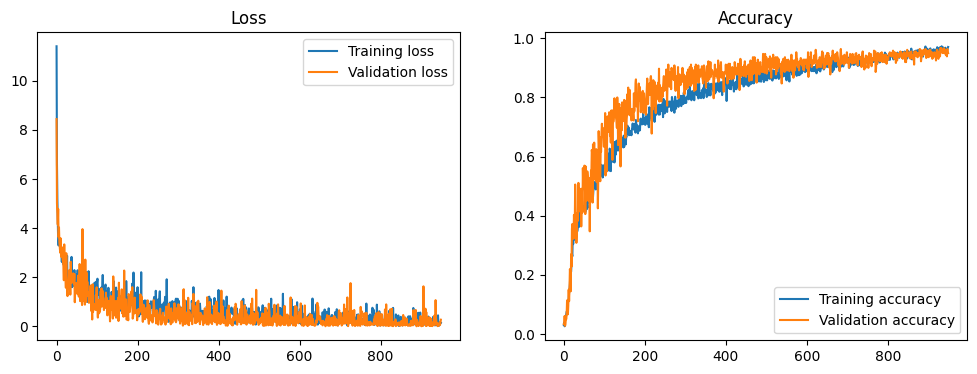

Epoch [951/1100], Loss: 0.3163699209690094, Accuracy: 0.9682539682539683 Correct: 1220 Total: 1260 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.95 Validation loss: 0.38217175006866455 Correct: 342 Total: 360
Epoch [952/1100], Loss: 0.06769924610853195, Accuracy: 0.9682539682539683 Correct: 1220 Total: 1260 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.08178931474685669 Correct: 344 Total: 360
Epoch [953/1100], Loss: 0.202633798122406, Accuracy: 0.9658730158730159 Correct: 1217 Total: 1260 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.95 Validation loss: 0.13644853234291077 Correct: 342 Total: 360
Epoch [954/1100], Loss: 0.13238100707530975, Accuracy: 0.969047619047619 Correct: 1221 Total: 1260 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.16937975585460663 Correct: 344 Total: 360
Epoch [955/1100], Loss: 

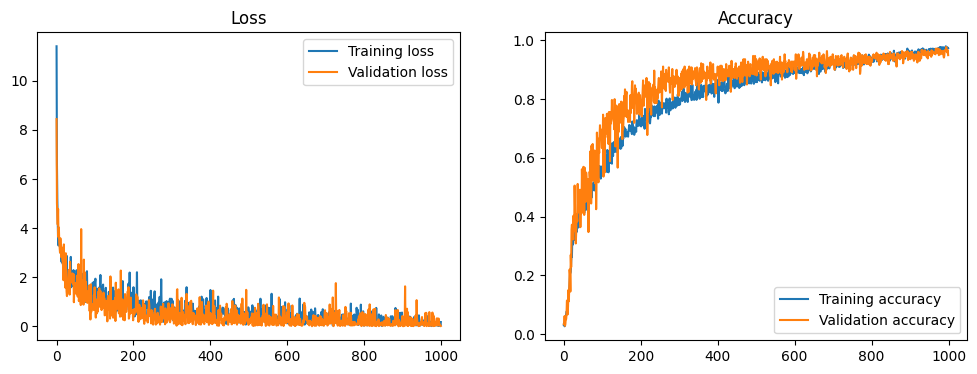

Epoch [1001/1100], Loss: 0.19425199925899506, Accuracy: 0.9682539682539683 Correct: 1220 Total: 1260 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9527777777777777 Validation loss: 0.11309569329023361 Correct: 343 Total: 360
Epoch [1002/1100], Loss: 0.1118510290980339, Accuracy: 0.9722222222222222 Correct: 1225 Total: 1260 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9583333333333334 Validation loss: 0.07814832776784897 Correct: 345 Total: 360
Epoch [1003/1100], Loss: 0.040191784501075745, Accuracy: 0.973015873015873 Correct: 1226 Total: 1260 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.21727833151817322 Correct: 348 Total: 360
Epoch [1004/1100], Loss: 0.046327218413352966, Accuracy: 0.9793650793650793 Correct: 1234 Total: 1260 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.3711509108543396 Correct: 34

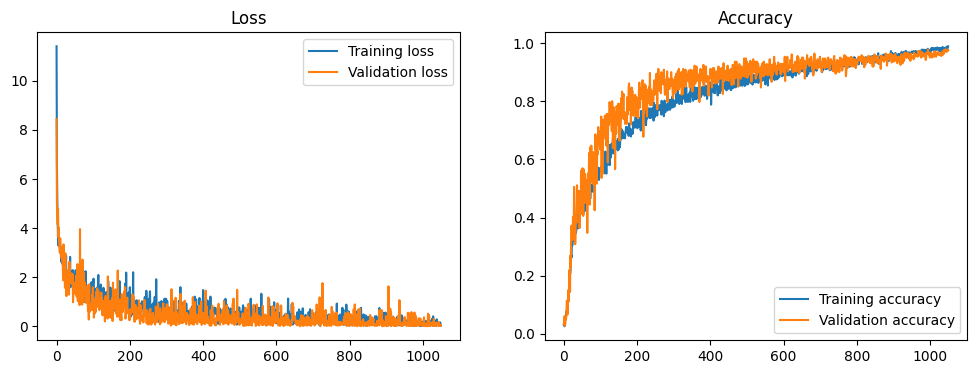

Epoch [1051/1100], Loss: 0.02623610384762287, Accuracy: 0.9817460317460317 Correct: 1237 Total: 1260 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.028010863810777664 Correct: 354 Total: 360
Epoch [1052/1100], Loss: 0.10395451635122299, Accuracy: 0.9833333333333333 Correct: 1239 Total: 1260 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.18668866157531738 Correct: 350 Total: 360
Epoch [1053/1100], Loss: 0.41961225867271423, Accuracy: 0.9809523809523809 Correct: 1236 Total: 1260 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.975 Validation loss: 0.09554746001958847 Correct: 351 Total: 360
Epoch [1054/1100], Loss: 0.10965312272310257, Accuracy: 0.9761904761904762 Correct: 1230 Total: 1260 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.05966055765748024 Correct: 350 Total

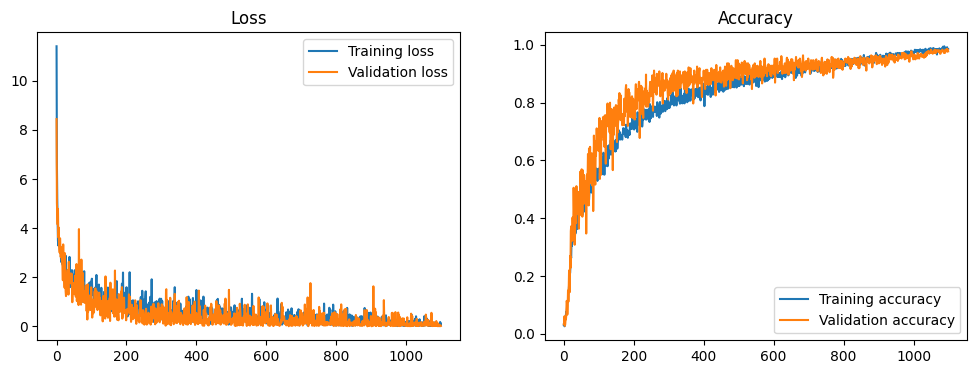

In [43]:
# Train Loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in combined_train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in combined_val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [44]:
save_model(model, model_path)

# Test

In [45]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [46]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-temp.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

In [47]:
cm = predict(combined_test_dataloader)

/tmp/ipykernel_91446/3471023847.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack([torch.tensor(d) for d in data])


Test Accuracy: 0.9777777777777777


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
predicted_labels,N,L,9,N,5,4,F,F,9,7,O,O,K,3,2,U,S,I,K,3,I,W,P,Y,5,Q,C,X,6,L,7,E,R,S,T,K,J,A,M,4,7,H,P,Y,X,G,B,S,D,R,X,O,G,9,2,0,P,3,Z,1,Y,C,K,Y,W,I,4,R,L,M,X,B,A,8,E,R,E,G,E,V,J,0,H,6,A,U,S,0,F,B,P,W,W,1,P,6,V,I,M,W,Z,9,L,Q,A,5,J,T,Y,7,P,C,Z,S,O,J,M,D,H,F,R,H,D,6,X,6,U,C,Z,V,8,I,A,T,R,Q,L,3,M,U,8,O,2,Q,N,1,B,3,2,3,B,W,G,R,1,V,E,J,5,5,D,N,1,U,1,H,0,7,X,9,R,T,Z,J,S,B,2,F,8,C
true_labels,N,L,9,N,5,4,F,F,9,7,O,O,K,3,2,U,S,I,K,3,I,W,P,Y,5,Q,C,X,6,L,7,E,R,S,T,K,J,A,M,4,7,H,P,Y,X,G,B,S,D,4,X,O,G,9,2,0,P,3,Z,1,Y,C,K,Y,W,I,4,R,L,M,X,N,A,8,E,T,E,G,E,V,J,0,H,6,A,U,S,0,F,B,P,W,W,1,P,6,V,I,M,W,Z,9,L,Q,A,5,K,T,Y,7,P,C,Z,S,O,J,M,D,H,F,R,H,D,6,X,6,U,C,Z,V,8,I,A,T,R,Q,L,3,M,U,8,O,2,Q,N,1,B,3,2,3,B,W,G,R,1,V,E,J,5,5,D,N,1,U,1,H,0,7,X,9,R,T,Z,J,S,B,2,F,8,C


0.9777777777777777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         6
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         4
        

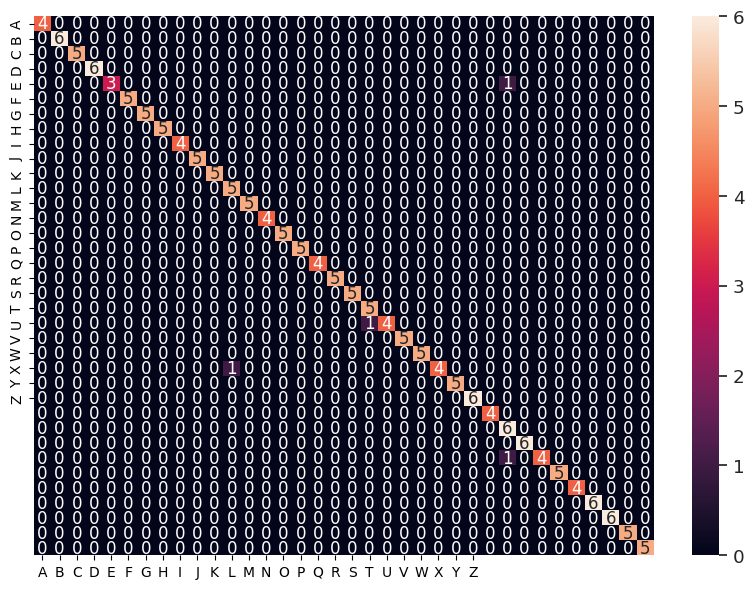

In [48]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1-temp")